In [134]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

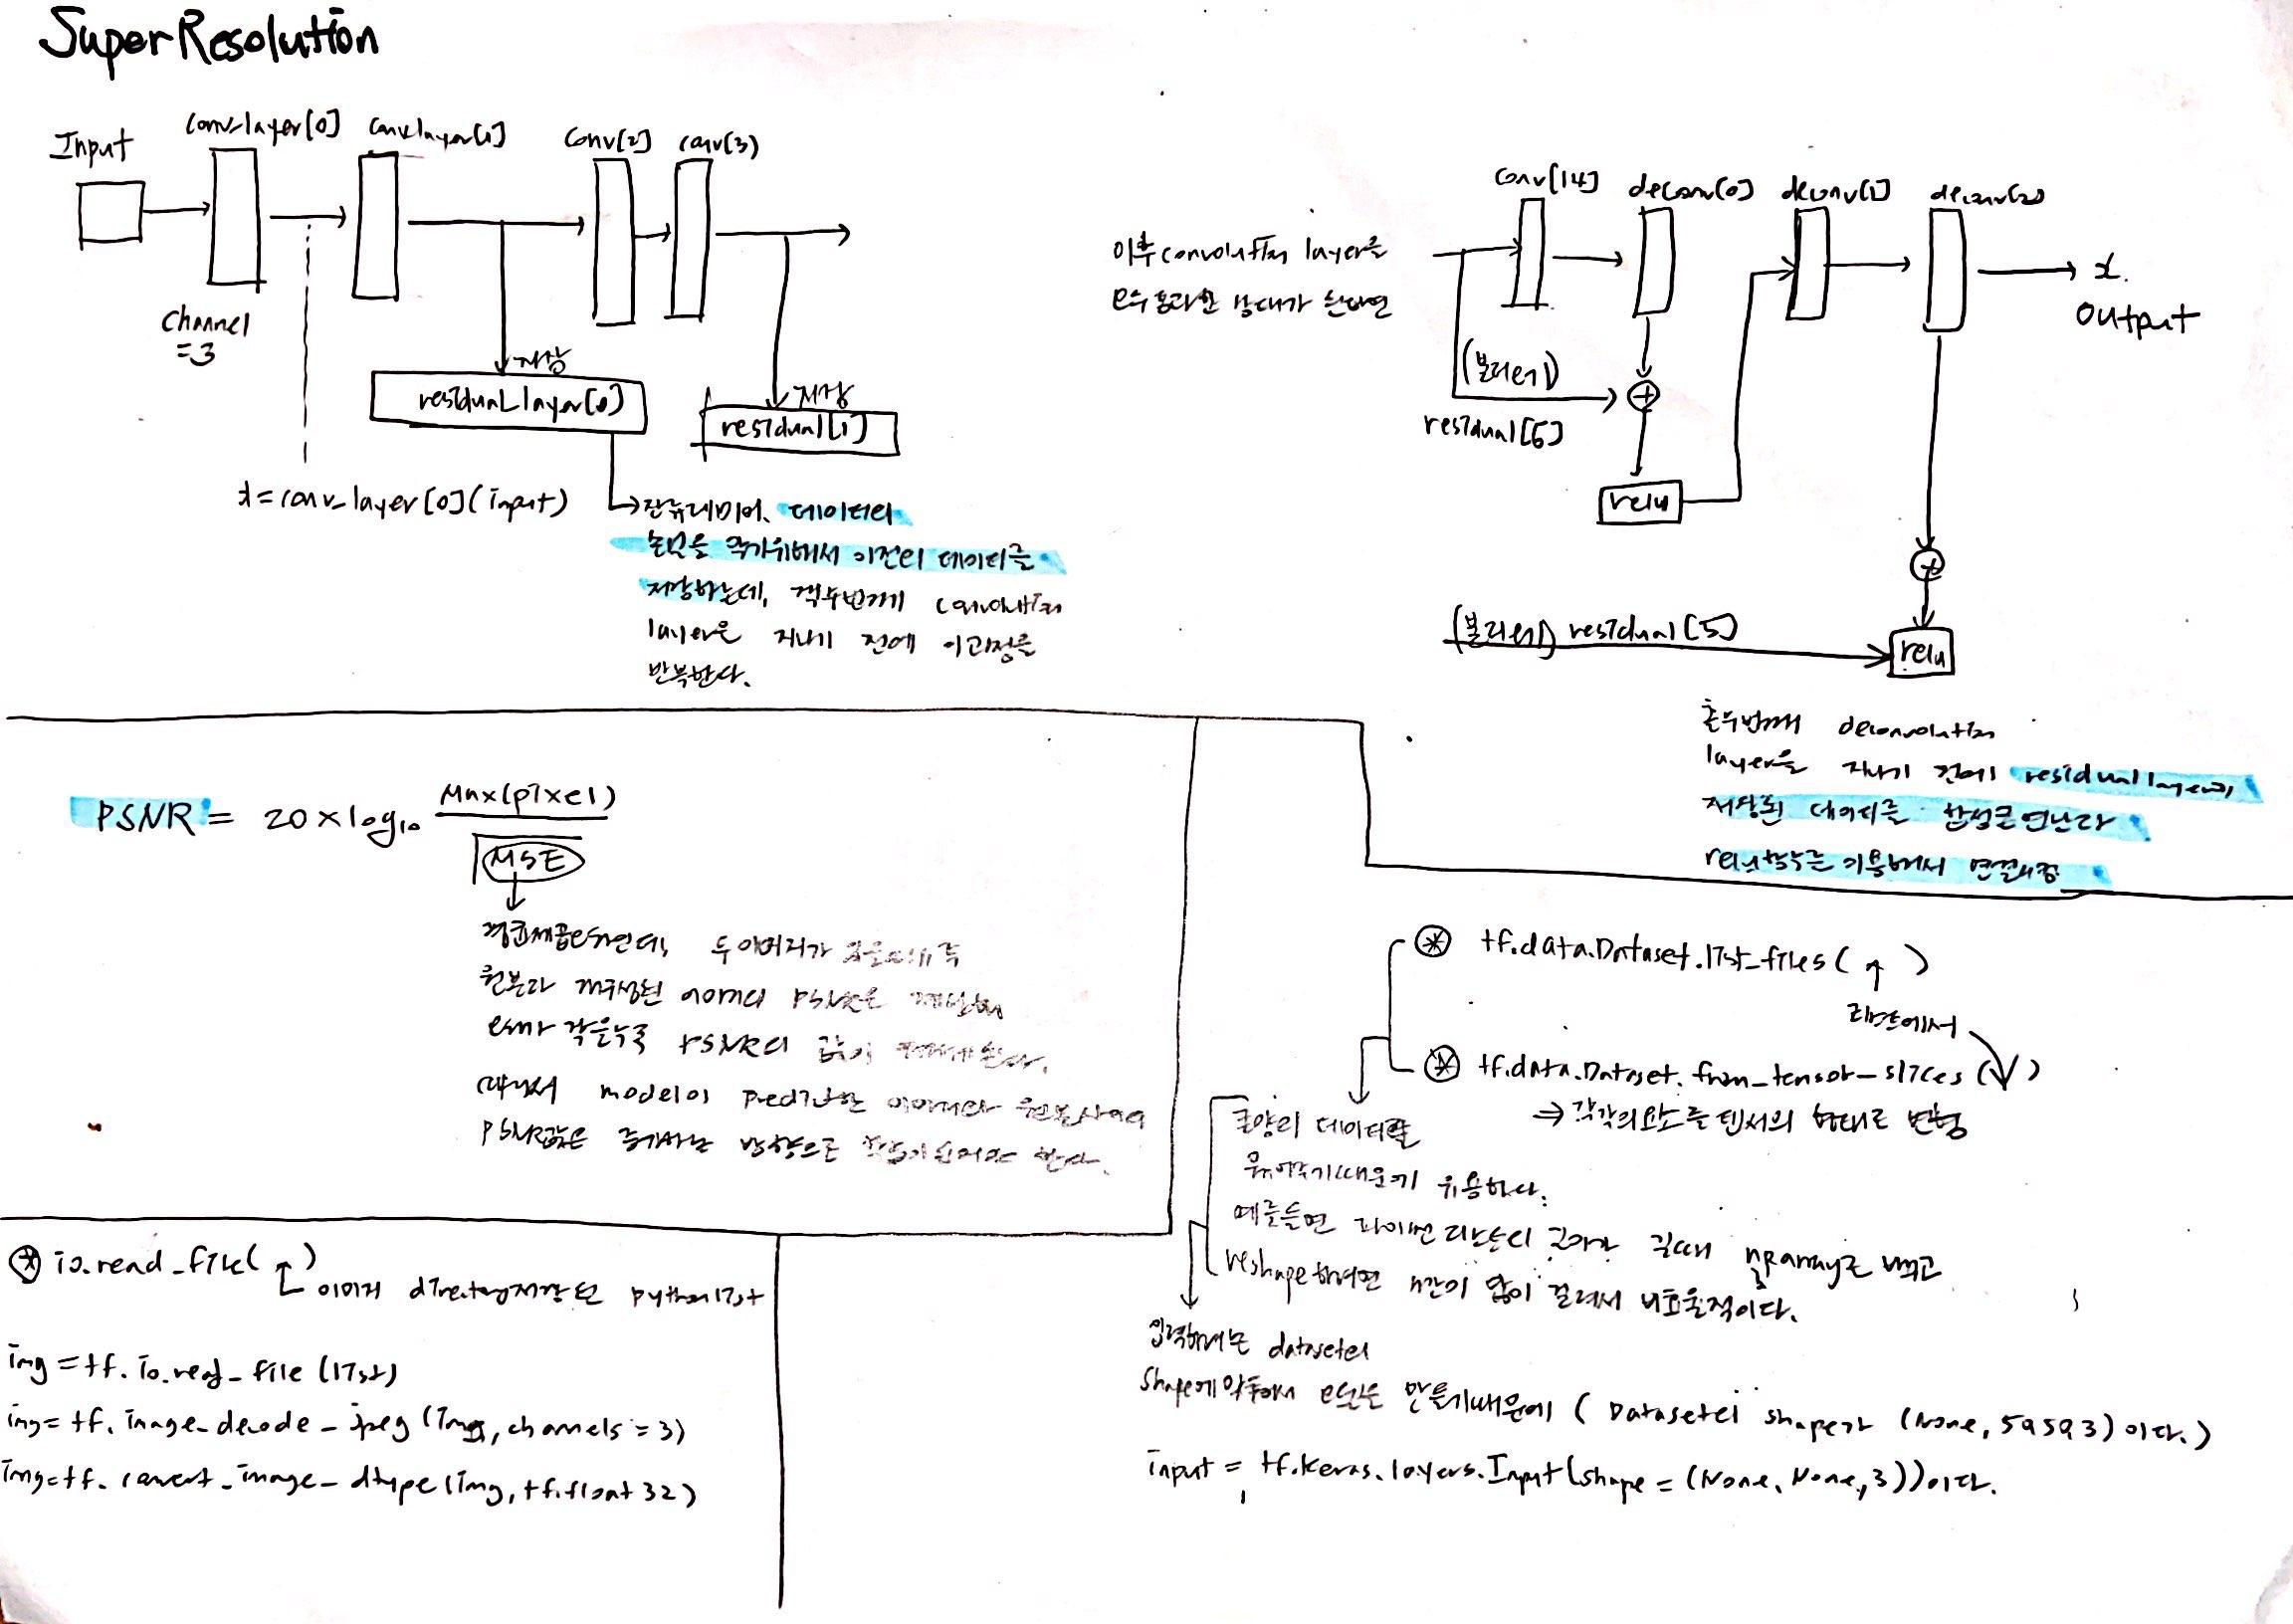

### Super Resolution
- '픽셀'이라는 것은 디지털 이미지의 최소 단위이다.
- 때문에 픽셀로 구성이 된 이미지는 고해상도의 이미지로 변환하려면 픽셀이 깨지기 때문에 이미지를 인식하기가 힘들다.
- 따라서 이럴때 super resolution을 진행하는데, 이 이외의 방법으로 주변 픽셀값과 비슷한 값으로 보간하는 기법이 있기는 하지만 이렇게 하면 선명함도 잃고 흐릿해지게 된다.

**이것 또한 Autoencoder을 이용한 방법이다.**
- 오토인코딩의 목적을 다시 살펴보자면 압축과 확장을 각각 Encoder과 Decoder을 이용해서 수행함으로서 입력 이미지와 동일한 이미지를 출력할 수 있도록 하는 것이었다.
- 하지만 Convolution layer과 Deconvolution layer을 거치는 과정에서 분명히 소실되는 데이터가 존재하기 때문에, 그런 레이어를 거친 이후에 Residial(skip-connection) layer을 삽입해 주기로 한다.
    - 이를 이용하면 앞쪽의 정보를 잃어버리지 않고 뒤쪽으로 전달하는 것이 가능할 것이다.

이렇게 구성이 된 모델을 **RED Net**이라고 하는데, BSD500 데이터 세트를 이용해서 이 모델을 구현해 보고자 한다.

**여기서 저장된 이미지의 베이스 디렉토리로부터 저장된 이미지의 경로를 모두 불러오는 방법에 대해 한가지 더 알게 되었다.**
- 원래는 그냥 import os를 이용했었는데 그렇게 하기보다는 ```import pathlib```를 사용하는 것도 괜찮은 것같다.

#### 이미지 불러오기 1. import os

In [167]:
import os
import cv2
base_dir = 'C:\images'
other = ['test', 'train', 'val']
train_dir, test_dir, val_dir = [],[],[]
for i in range(3):
    path = os.path.join(base_dir, other[i])
    file = os.listdir(path)
    for k in file:
        newpath = os.path.join(path, k)
        if i == 0:test_dir.append(newpath)
        elif i == 1:train_dir.append(newpath)
        else:val_dir.append(newpath)
        

#### 이미지 불러오기 2. import pathlib
1. 각 이미지의 경로는 루트 디렉터리에서 ```glob()```함수를 이용해서 하단의 모든 파일을 불러 올 수 있다
2. 각 파일의 경로는 str()을 앞에 붙여서 사용하면 된다.

In [136]:
import pathlib
image_root = pathlib.Path(base_dir)

all_img_path = list(image_root.glob('*/*'))
print(all_img_path[:10])

[WindowsPath('C:/images/test/100007.jpg'), WindowsPath('C:/images/test/100039.jpg'), WindowsPath('C:/images/test/100099.jpg'), WindowsPath('C:/images/test/10081.jpg'), WindowsPath('C:/images/test/101027.jpg'), WindowsPath('C:/images/test/101084.jpg'), WindowsPath('C:/images/test/102062.jpg'), WindowsPath('C:/images/test/103006.jpg'), WindowsPath('C:/images/test/103029.jpg'), WindowsPath('C:/images/test/103078.jpg')]


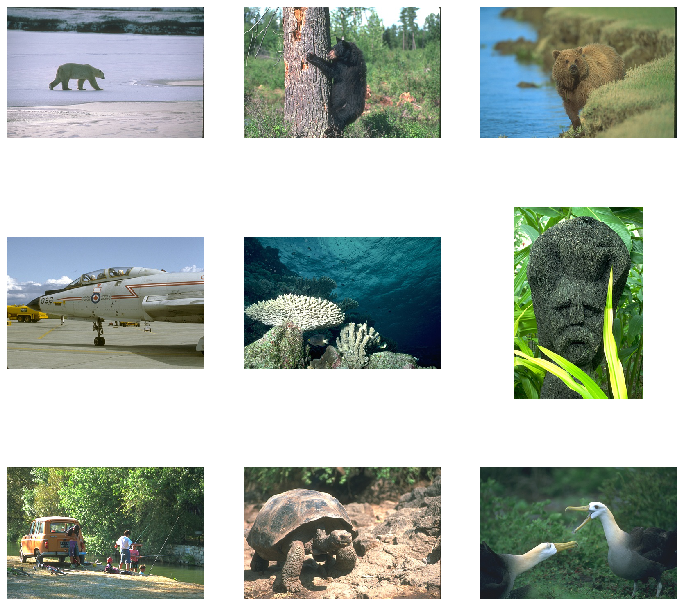

In [137]:
import PIL.Image as Image

plt.figure(figsize = (12,12))
for d in range(9):
    plt.subplot(3,3,d+1)
    plt.imshow(plt.imread(str(all_img_path[d])))
    plt.axis('off')
plt.show()

**이미지를 matplotlib를 이용해서 불러온 결과 사진마다 가로, 세로의 길이가 각각 다름을 알 수 있다.**
- 현재 가지고 있는 이미지는 고해상도인데, 그렇기 때문에 이미지의 해상도를 일부러 낮추고 원본과 함께 반환하는 과정이 필요하다.
- 저해상도의 이미지를 만드는 과정은 **이미지에서 가로x세로 50픽셀의 작은 조각을 잘라내는 것**이다.
- 이렇게 만들어진 저해상도의 이미지는 학습에서 모델의 입력값으로 이용이 될 것이고, 실제로 모델의 입력과 출력이 완전히 같은 것은 아니지만 오토인코더의 원리로도 충분히 학습이 가능하다.

- ```tf.io.read_file()```을 이용해서 JPEG이미지를 불러올 수 있다.
- 이렇게 이미지를 불러온 이후에는 ```decode_jpeg()```를 이요애서 프로그램이 이해할 수 있는 데이터의 형태로 만들고
- ```convert_image_dtype()```를 이용해서 딥러닝에서 가장 많이 사용하는 float32데이터 타입을 만든다.

In [143]:
img = tf.io.read_file(train_dir[0])
img = tf.image.decode_jpeg(img, channels = 3)
#이렇게 하면 저절로 0에서 1사이의 scale로 픽셀값을 바꿔줌
img = tf.image.convert_image_dtype(img, tf.float32)
print(tf.image.random_crop(img,[50,50,3]))

tf.Tensor(
[[[0.22352943 0.38431376 0.3921569 ]
  [0.22352943 0.38823533 0.38431376]
  [0.22352943 0.38823533 0.38431376]
  ...
  [0.17254902 0.34509805 0.34117648]
  [0.16470589 0.3372549  0.33333334]
  [0.15686275 0.3372549  0.32941177]]

 [[0.21176472 0.36862746 0.36862746]
  [0.20784315 0.3647059  0.3647059 ]
  [0.21568629 0.37254903 0.37254903]
  ...
  [0.16862746 0.34509805 0.33333334]
  [0.16862746 0.34509805 0.33333334]
  [0.17254902 0.34901962 0.3372549 ]]

 [[0.22352943 0.38431376 0.36862746]
  [0.22352943 0.3803922  0.37647063]
  [0.227451   0.3803922  0.36862746]
  ...
  [0.16862746 0.33333334 0.31764707]
  [0.18039216 0.34509805 0.3372549 ]
  [0.18039216 0.35686275 0.3372549 ]]

 ...

 [[0.78823537 0.59607846 0.4666667 ]
  [0.7568628  0.5647059  0.43529415]
  [0.7411765  0.56078434 0.41960788]
  ...
  [0.654902   0.5372549  0.39607847]
  [0.67058825 0.54509807 0.39607847]
  [0.65882355 0.53333336 0.38431376]]

 [[0.8000001  0.61960787 0.48627454]
  [0.7960785  0.6039216  0

In [170]:
def get_both_img_1(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    #이렇게 하면 저절로 0에서 1사이의 scale로 픽셀값을 바꿔줌
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    noise = tf.image.random_crop(img, [50,50,3])
    new = tf.image.resize(noise, [25,25])
    new = tf.image.resize(new, [50,50])
    return (new, noise)

In [168]:
train_dir = train_dir[:-1]
test_dir = test_dir[:-1]
val_dir = val_dir[:-1]

In [176]:
len(train_dir),len(test_dir), len(val_dir)

(200, 200, 100)

In [150]:
def get_both_img_2(image_path):
    for i in image_path:
        img = cv2.imread(i, cv2.IMREAD_COLOR)
        #차후에 데이터를 보고 정규화를 진행해야 함
        img = np.asarray(img).astype('float32')
    
        noise = tf.image.random_crop(img, [50,50,3])
        new = tf.image.resize(noise, [25,25])
        new = tf.image.resize(new, [50,50])
        return new, noise

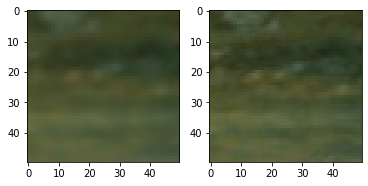

In [44]:
data = get_both_img_2(train_dir[0])
plt.figure(figsize = (6,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(data[i]/255)
plt.show()

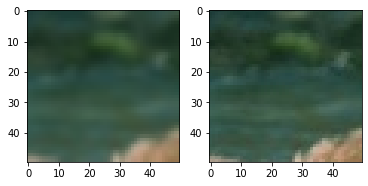

In [47]:
data = get_both_img_1(train_dir[0])
plt.figure(figsize = (6,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(data[i])
plt.show()

2-1.```tf.data.Dataset```을 이용하는 방법

In [183]:
training_dataset = tf.data.Dataset.list_files(train_dir)
training_dataset = training_dataset.map(get_both_img_1)
training_dataset = training_dataset.repeat()
training_dataset = training_dataset.batch(16)

valid_dataset = tf.data.Dataset.list_files(val_dir)
valid_dataset = valid_dataset.map(get_both_img_1)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(1)

In [184]:
print(np.asarray(training_dataset))

<DatasetV1Adapter shapes: ((None, 50, 50, 3), (None, 50, 50, 3)), types: (tf.float32, tf.float32)>


In [185]:
print(np.asarray(valid_dataset))

<DatasetV1Adapter shapes: ((None, 50, 50, 3), (None, 50, 50, 3)), types: (tf.float32, tf.float32)>


In [120]:
x_train, y_train = [],[]
for i in train_dir:
    a,b = get_both_img_2(i)
    x_train.append(a)
    y_train.append(b)
x_val, y_val = [],[]
for i in val_dir:
    a,b = get_both_img_2(i)
    x_val.append(a)
    y_val.append(b)

**구현하고자 하는 네트워크는 기존의 모델들 처럼 직선형구조가 아니기 때문에 ```Sequential()```을 사용할 수 없다.**  
따라서 keras의 함수형 API를 이용하고자 한다.  

1. 입력값의 데이터의 shape를 (None, None, 3)이라고 설정함으로서 어떤 크기의 이미지라도 입력으로 받을 수 있도록 한다.
2. convolution layer의 첫번째 층과 deconvolution layer의 마지막 층은 RGB형태의 이미지를 각각 입력과 출력을 하기 위해서 channel의 수를 3으로 설정
3. x라는 변수를 이용해서 반복적으로 레이어에 적용해 나간다

- 사실 keras의 함수형 API를 사용해서 모델을 정의하는 것에 거부감이 있었는데 **input과 output만 정의**해주면 되는 것이었다.
- 입력인 input은 함수의 가장 앞에서 정의되는 입력 레이어이고, 출력인 output은 지금까지 레이어 연산을 쭉 따라온 변수이름인 x로 넣고 ```model = tf.keras.models.Model(inputs = inputs, ouputs = x)```이렇게 모델을 정의해 주면 된다.


In [127]:
def REDnet(num_layers):
    conv_layer, residual_layer, deconv_layer = [],[],[]
    
    inputs = tf.keras.layers.Input(shape = (None,None,3))
    conv_layer.append(tf.keras.layers.Conv2D(3, kernel_size = (3,3), padding = 'same', activation = 'relu'))
    
    for i in range(num_layers-1):
        conv_layer.append(tf.keras.layers.Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
        deconv_layer.append(tf.keras.layers.Conv2DTranspose(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
        
    deconv_layer.append(tf.keras.layers.Conv2DTranspose(3, kernel_size = (3,3), padding = 'same'))
    
    x = conv_layer[0](inputs)
    
    for i in range(num_layers-1):
        x = conv_layer[i+1](x)
        if i%2 == 0:
            residual_layer.append(x)
    
    for i in range(num_layers-1):
        if i%2 == 1:
            x = tf.keras.layers.Add()([x, residual_layer.pop()])
            x = tf.keras.layers.Activation('relu')(x)
        x = deconv_layer[i](x)
        
    x = deconv_layer[-1](x)
    
    model = tf.keras.Model(inputs =inputs, outputs = x)
    return model

고해상도 이미지로 복원이 잘 되었는지 확인해 주기 위해서 PSNR(Peak-Signal-to-Noise Ratio)라는 값을 정해주는데, 이는 '신호 대 잡음비'이다.  
원본 이미지와 재구성된 이미지의 PSNR값을 계산하면 이미지의 품질을 측정할 수 있는데, 수식은 **20 * ln(Max(pixel)/(MSE)^0.5)**이다.

- 여기서 이미지의 픽셀 값들을 float의 형태로 바꾸었으므로 max(pixel)의 값은 1이다.
- 이미지의 PSNR의 값이 높을수록 해상도가 더 높기 때문에 학습 이후에 시각화 만으로 해상도를 판단할 수 없기 때문에 수치적으로 비교하는 것이 좋다.

In [128]:
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val = 0.1)

In [130]:
model = REDnet(15)
model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'mse', metrics = [psnr_metric])

In [131]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, None, None, 3 84          input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, None, None, 6 1792        conv2d_75[0][0]                  
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, None, None, 6 36928       conv2d_76[0][0]                  
____________________________________________________________________________________________

In [187]:
hist = model.fit_generator(
    training_dataset,epochs = 150, steps_per_epoch = len(train_dir)//16, validation_data = valid_dataset, validation_steps = len(val_dir)
)

Epoch 1/150
12/12 [==============================] - 49s 4s/step - loss: 0.0078 - psnr_metric: 2.5677 - val_loss: 0.0061 - val_psnr_metric: 3.4439
Epoch 2/150
12/12 [==============================] - 50s 4s/step - loss: 0.0064 - psnr_metric: 3.3444 - val_loss: 0.0061 - val_psnr_metric: 3.6496
Epoch 3/150
12/12 [==============================] - 52s 4s/step - loss: 0.0063 - psnr_metric: 3.7889 - val_loss: 0.0050 - val_psnr_metric: 4.9068
Epoch 4/150
12/12 [==============================] - 52s 4s/step - loss: 0.0066 - psnr_metric: 3.8019 - val_loss: 0.0050 - val_psnr_metric: 4.8220
Epoch 5/150
12/12 [==============================] - 51s 4s/step - loss: 0.0058 - psnr_metric: 4.1146 - val_loss: 0.0056 - val_psnr_metric: 3.7743
Epoch 6/150
12/12 [==============================] - 53s 4s/step - loss: 0.0057 - psnr_metric: 4.0495 - val_loss: 0.0051 - val_psnr_metric: 4.7369
Epoch 7/150
12/12 [==============================] - 52s 4s/step - loss: 0.0048 - psnr_metric: 4.9763 - val_loss: 0.00

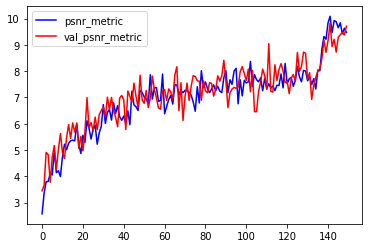

In [191]:
plt.plot(hist.history['psnr_metric'], 'b-', label = 'psnr_metric')
plt.plot(hist.history['val_psnr_metric'], 'r-', label = 'val_psnr_metric')
plt.legend()
plt.show()

In [194]:
#이미지 하나를 불러와서 예측을 시켜보기로 하자.
#위에서 50*50 크기의 픽셀의 데이터를 'batch'해서 학습했기 때문에
#테스트 이미지의 크기를 반으로 줄였다가 다시 확대함으로서 저화질의 이미지를 만들었다.
path = tf.keras.utils.get_file('butterfly.png', 'http://bit.ly/2oAOxgH')
img = tf.io.read_file(path)
img = tf.image.decode_jpeg(img, channels = 3)
real = tf.image.convert_image_dtype(img, tf.float32)

change = tf.image.resize(real, [real.shape[0]//2, real.shape[1]//2])
change = tf.image.resize(change, [real.shape[0], real.shape[1]])
pred = model.predict(np.expand_dims(change, axis = 0))

print(tf.image.psnr(np.squeeze(pred, axis = 0), real, max_val = 1.0))
print(tf.image.psnr(change, real, max_val = 1.0))

tf.Tensor(27.08258, shape=(), dtype=float32)
tf.Tensor(24.783775, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.


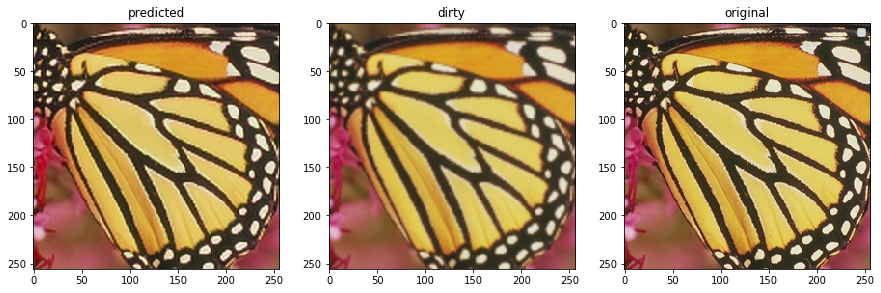

In [196]:
plt.figure(figsize = (15,15))

plt.subplot(1,3,1)
plt.imshow(np.squeeze(pred, axis = 0))
plt.title('predicted')

plt.subplot(1,3,2)
plt.imshow(change)
plt.title('dirty')

plt.subplot(1,3,3)
plt.imshow(real)
plt.title('original')

plt.legend()
plt.show()

**여기서 REDnet에 서정을 해서 좀더 복잡한 이미지 데이터를 다루어 볼 수 있다**  
예를 들면 확대 비율을 더 늘린다던가 25%의 확률로(```if np.random.random() < 0.25```)좌우 반전, 또는 상하 반전을 시켜 주어서 이미지 데이터의 개수를 훨씬 늘려서 학습을 더 많이 시켜볼 수 있다.